# Analysing Reliability of DOSPERT answers 20 LLMs

- We want to measure, for each LLM, how consistent it is in assigning probabilities across the 40-item answer patterns of a single human. Essentially: “Does the LLM consistently see the human’s answer pattern as more or less probable, or is it erratic?”

In [1]:
# packages
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import random
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import seaborn as sns
import pingouin as pg


# Initialize empty list to store DataFrames
dospert_dataframes = []

path = "LLM_data"  # folder with CSVs

for file in glob.glob(os.path.join(path, "*_DOSPERT_prompting_results.csv")):
    model_name = os.path.basename(file).replace("_DOSPERT_prompting_results.csv", "")
    
    # Read the CSV
    df = pd.read_csv(file)
    
    # Append to list
    dospert_dataframes.append(df)
    
# Concatenate all DataFrames into one big DataFrame
merged_dospert_data = pd.concat(dospert_dataframes, ignore_index=True)

print(f"\nMerged DataFrame shape: {merged_dospert_data.shape}")
print(f"Total models: {merged_dospert_data['model'].nunique()}")
print(f"Models included: {sorted(merged_dospert_data['model'].unique())}")

# add column with predicted logprob for actual human answers
merged_dospert_data['logprob_predicted'] = merged_dospert_data.apply(
    lambda row: np.exp(row[str(row['human_number'])]), axis=1
)
# Define mapping dictionary
item_to_category = {
    1: "Social", 10: "Social", 16: "Social", 19: "Social", 23: "Social", 26: "Social", 34: "Social", 35: "Social",
    2: "Recreational", 6: "Recreational", 15: "Recreational", 17: "Recreational", 21: "Recreational", 31: "Recreational", 37: "Recreational", 38: "Recreational",
    3: "Gambling", 11: "Gambling", 22: "Gambling", 33: "Gambling",
    4: "Health", 8: "Health", 27: "Health", 29: "Health", 32: "Health", 36: "Health", 39: "Health", 40: "Health",
    5: "Ethical", 9: "Ethical", 12: "Ethical", 13: "Ethical", 14: "Ethical", 20: "Ethical", 25: "Ethical", 28: "Ethical",
    7: "Investment", 18: "Investment", 24: "Investment", 30: "Investment"
}

# Add a new column "domain"
merged_dospert_data["domain"] = merged_dospert_data["item"].map(item_to_category)

# Check column names
print(f"\nColumns: {list(merged_dospert_data.columns)}")

merged_dospert_data = merged_dospert_data[merged_dospert_data["flipped"] == "no"]

merged_dospert_data.groupby("model")["logprob_predicted"].nunique()


Merged DataFrame shape: (2780240, 11)
Total models: 46
Models included: ['Apertus-70B-Instruct-2509', 'Apertus-8B-Instruct-2509', 'Falcon-3-10B-Instruct', 'Falcon-3-1B-Instruct', 'Falcon-3-7B-Instruct', 'LFM2-1.2B', 'LFM2-2.6B', 'LFM2-8B-A1B', 'Llama-3.1-70B-Instruct', 'Llama-3.1-8B-Instruct', 'Llama-3.2-1B-Instruct', 'Llama-3.2-3B-Instruct', 'Llama-3.3-70B-Instruct', 'Ministral-8B-Instruct-2410', 'Mistral-7B-Instruct-v0.3', 'Mistral-Small-24B-Instruct-2501', 'OLMo-2-7B-Instruct', 'Phi-3-medium-128k-instruct', 'Phi-3-mini-128k-instruct', 'Phi-3.5-mini-instruct', 'Qwen2.5-1.5B-Instruct', 'Qwen2.5-14B-Instruct', 'Qwen2.5-32B-Instruct', 'Qwen2.5-3B-Instruct', 'Qwen2.5-7B-Instruct', 'Qwen3-1.7B', 'Qwen3-14B', 'Qwen3-30B-A3B-Instruct-2507', 'Qwen3-32B', 'Qwen3-4B', 'Qwen3-8B', 'SmolLM3-3B', 'TildeOpen-30b', 'bloomz-3b', 'bloomz-7b1', 'gemma-2-27b-it', 'gemma-2-2b-it', 'gemma-2-9b-it', 'gemma-3-12b-it', 'gemma-3-1b-it', 'gemma-3-27b-it', 'gemma-3-4b-it', 'gpt-oss-20b', 'granite-3.3-2b-instr

model
Apertus-70B-Instruct-2509            164
Apertus-8B-Instruct-2509             162
Falcon-3-10B-Instruct                199
Falcon-3-1B-Instruct                 177
Falcon-3-7B-Instruct                 137
LFM2-1.2B                             98
LFM2-2.6B                            110
LFM2-8B-A1B                          142
Llama-3.1-70B-Instruct               155
Llama-3.1-8B-Instruct                 84
Llama-3.2-1B-Instruct                 68
Llama-3.2-3B-Instruct                 80
Llama-3.3-70B-Instruct               159
Ministral-8B-Instruct-2410           116
Mistral-7B-Instruct-v0.3             386
Mistral-Small-24B-Instruct-2501      135
OLMo-2-7B-Instruct                    70
Phi-3-medium-128k-instruct         26253
Phi-3-mini-128k-instruct           26271
Phi-3.5-mini-instruct              26271
Qwen2.5-1.5B-Instruct                157
Qwen2.5-14B-Instruct                 169
Qwen2.5-32B-Instruct                 206
Qwen2.5-3B-Instruct                  176
Qwen2.5-7B

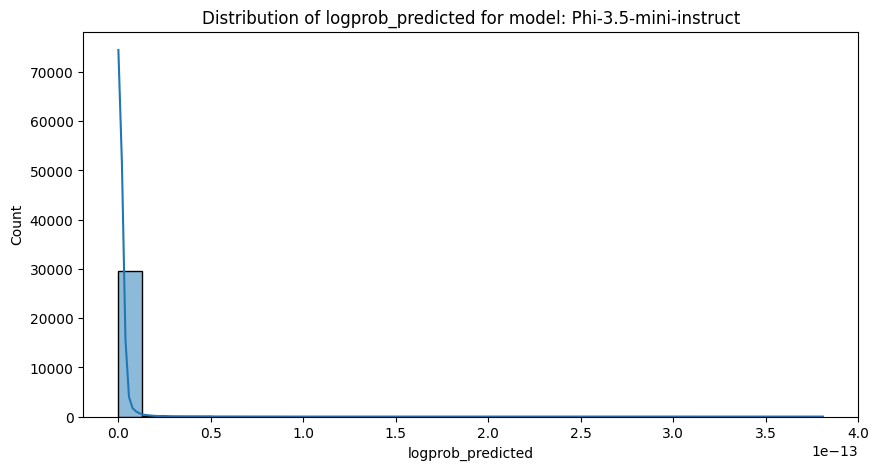

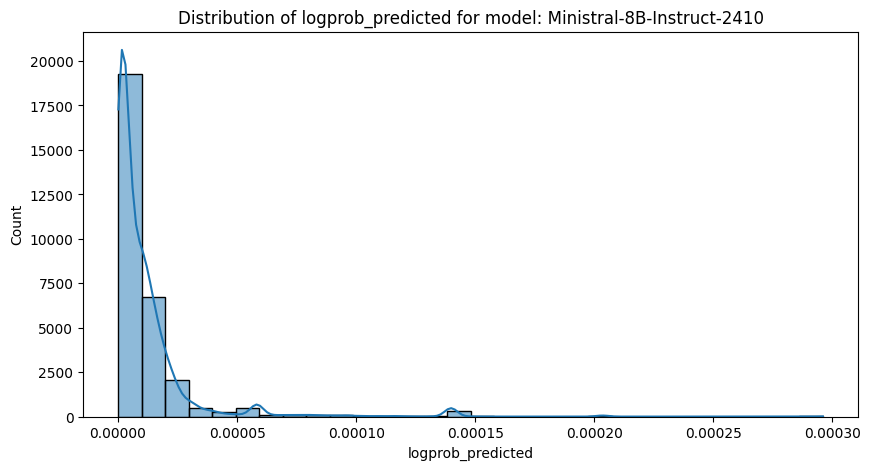

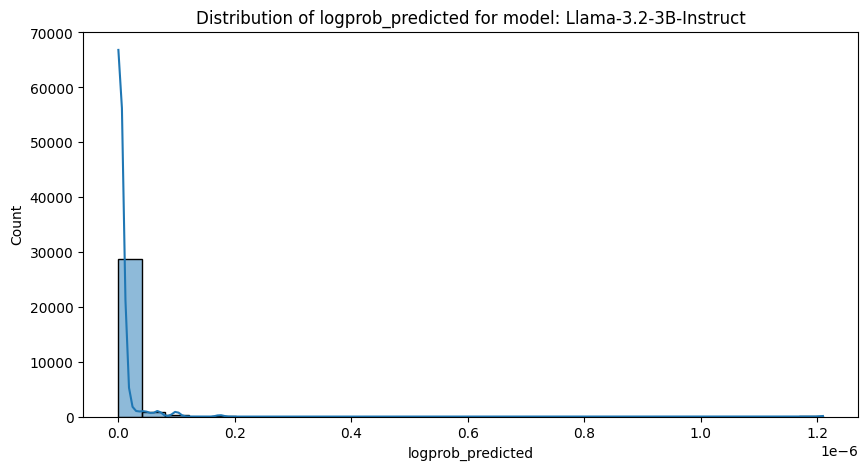

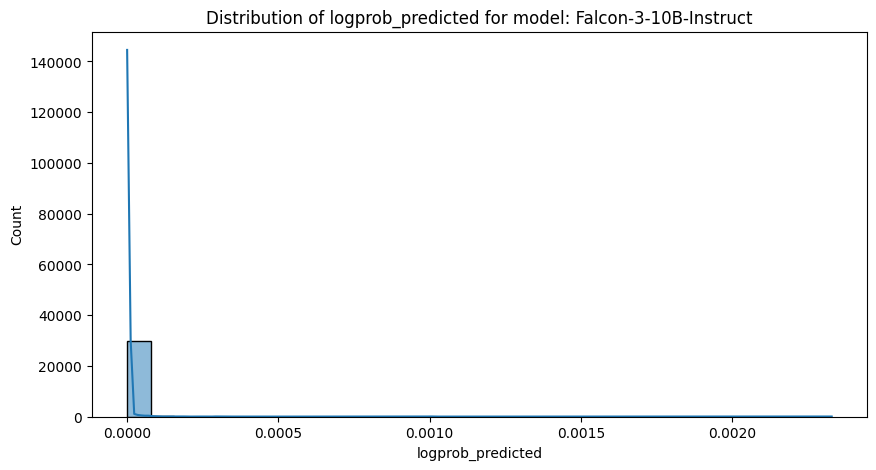

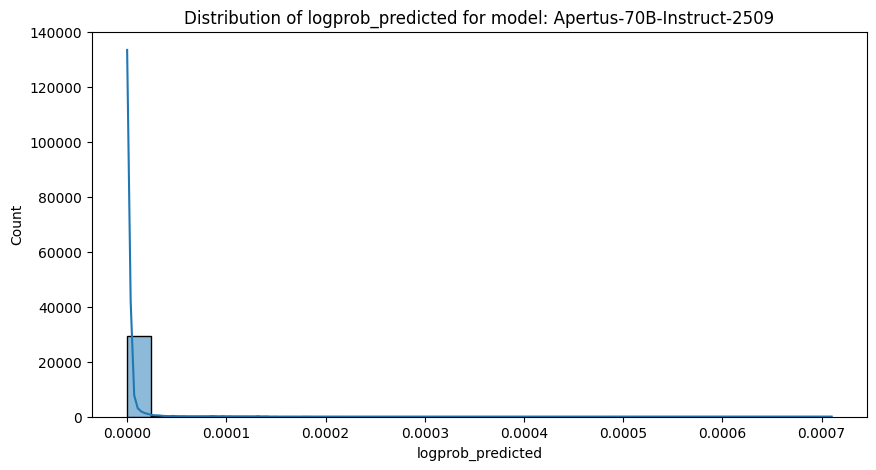

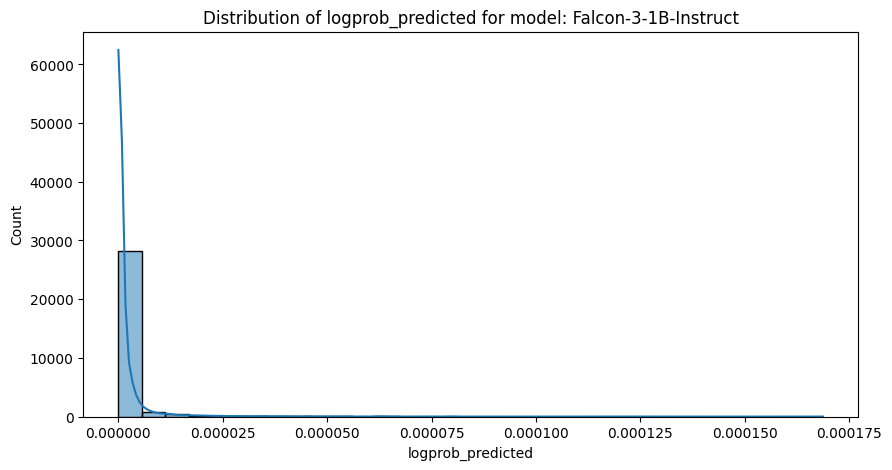

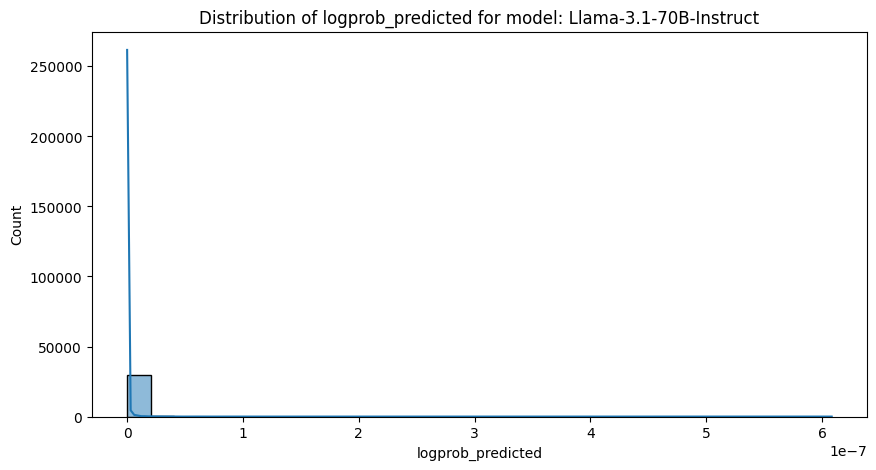

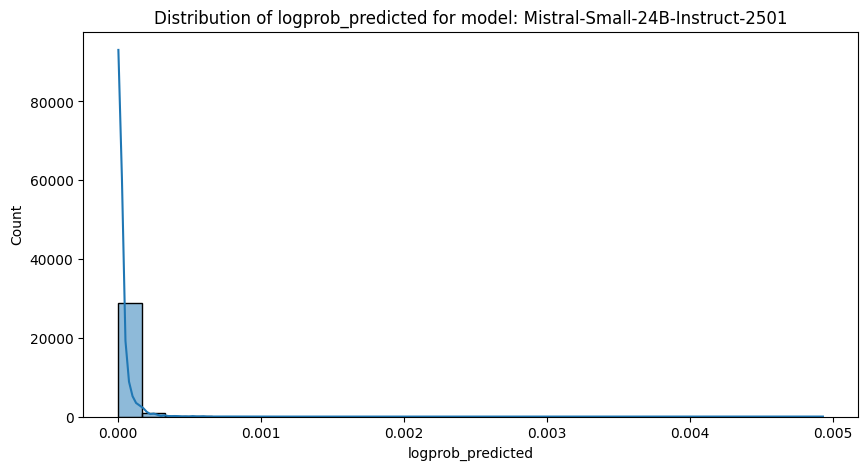

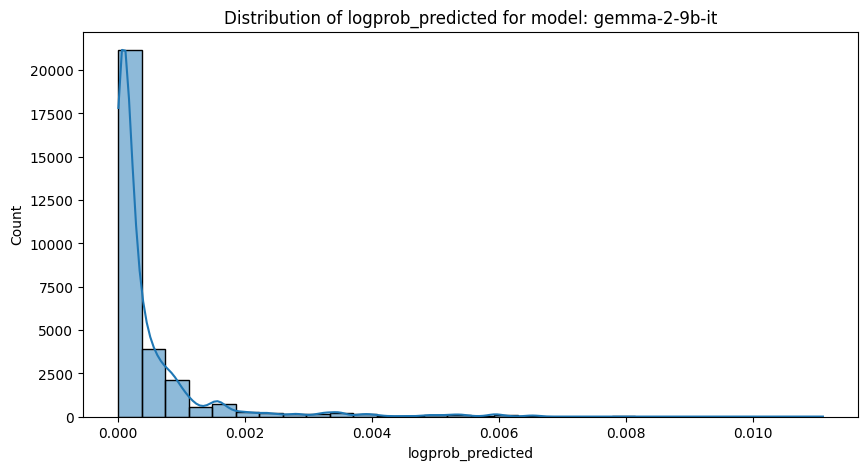

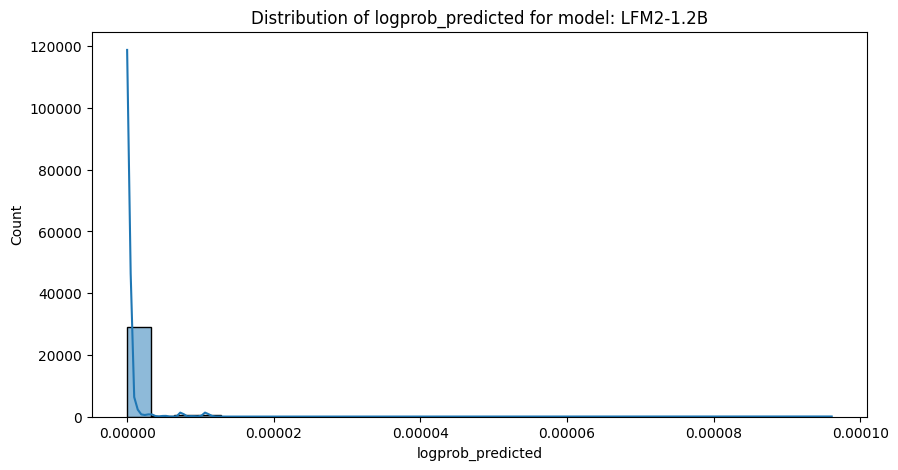

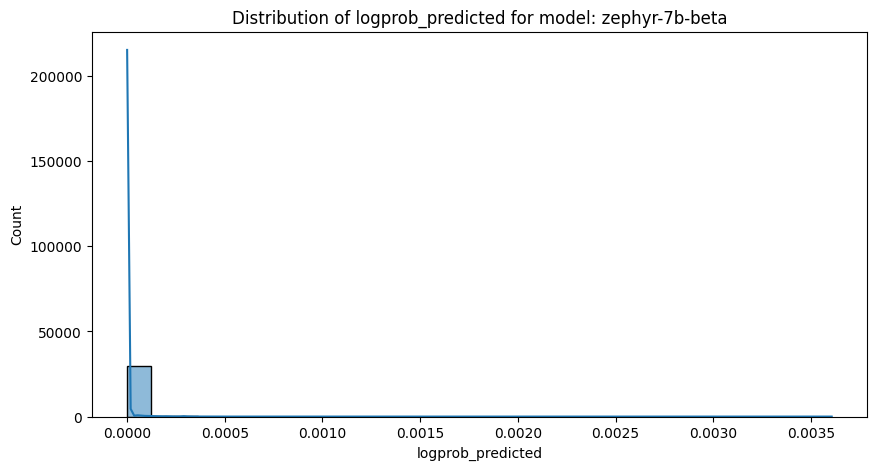

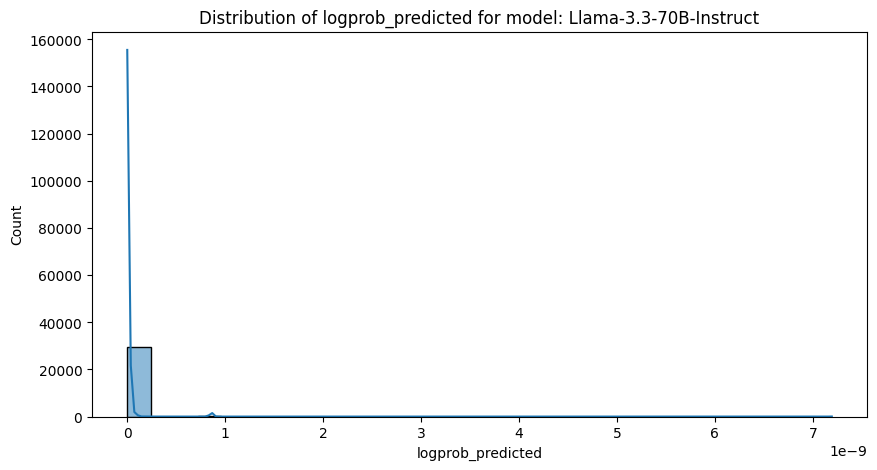

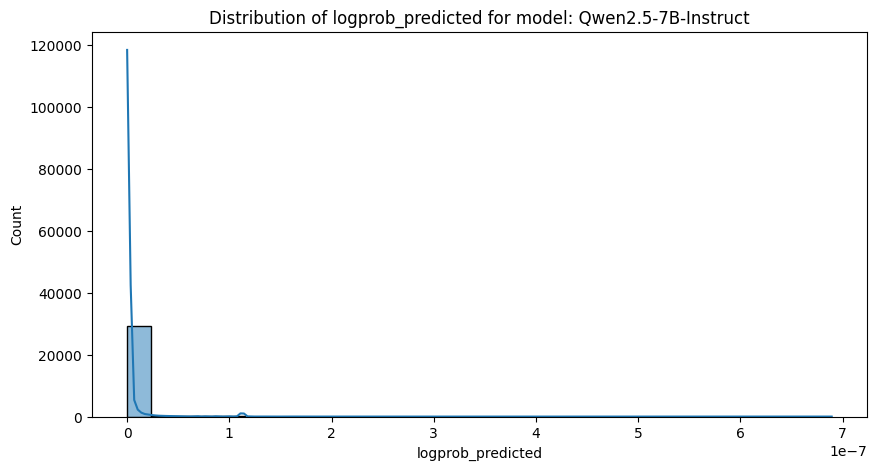

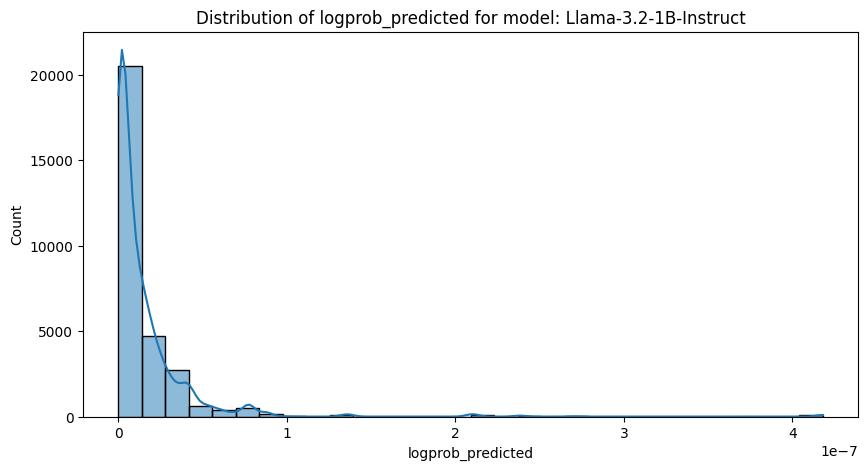

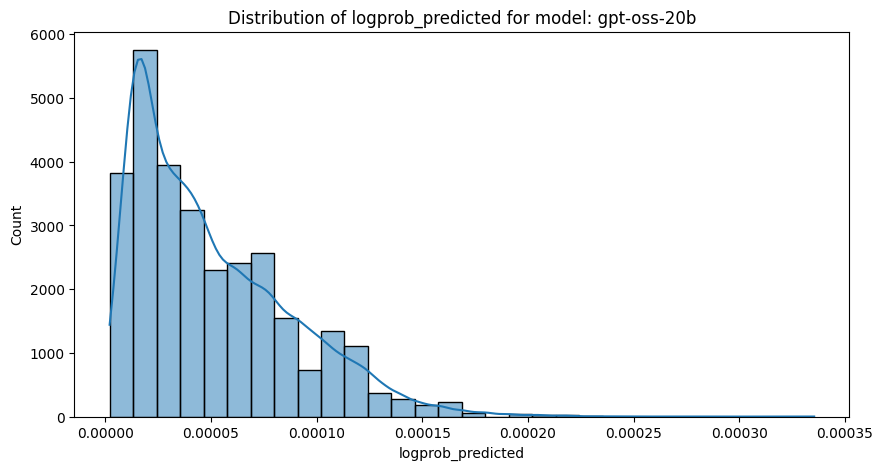

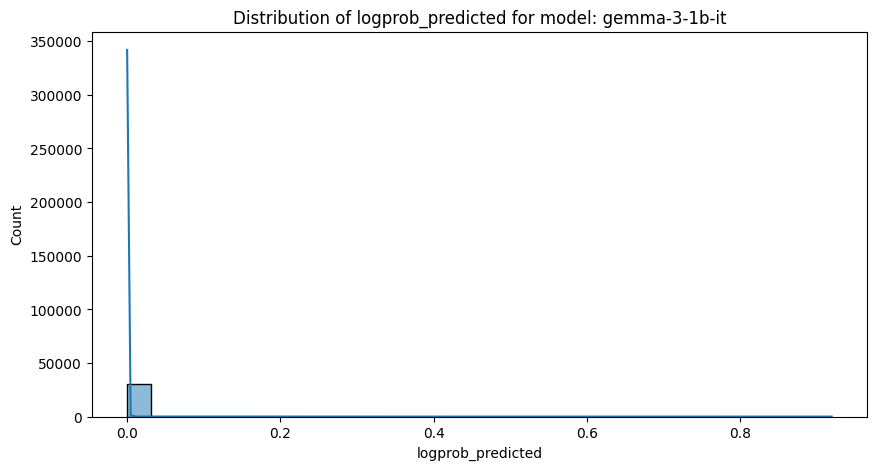

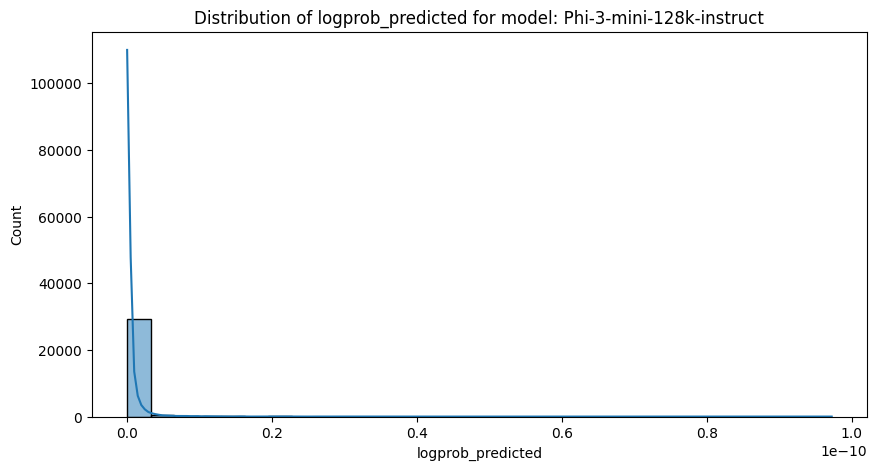

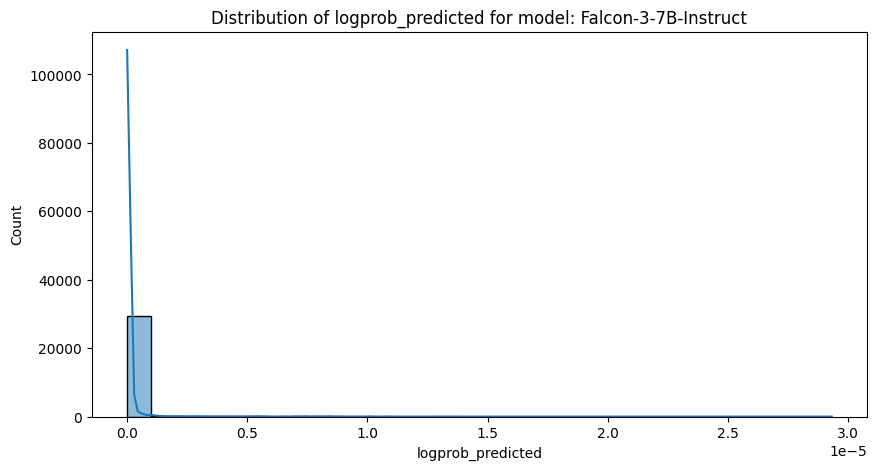

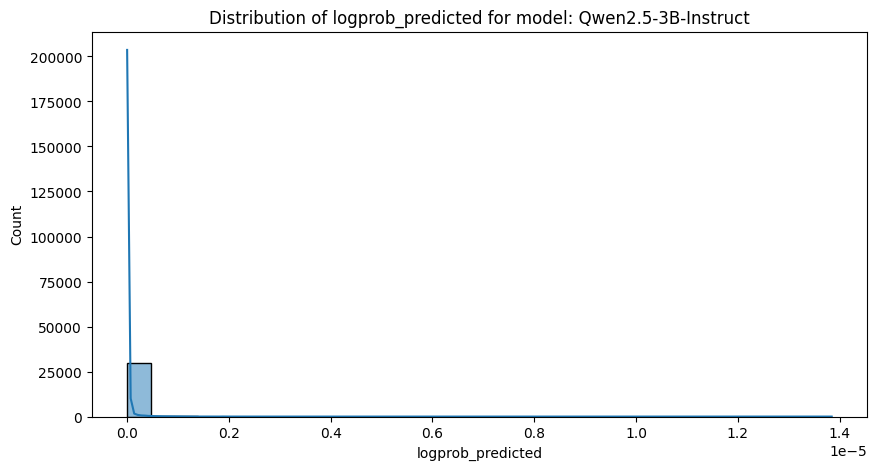

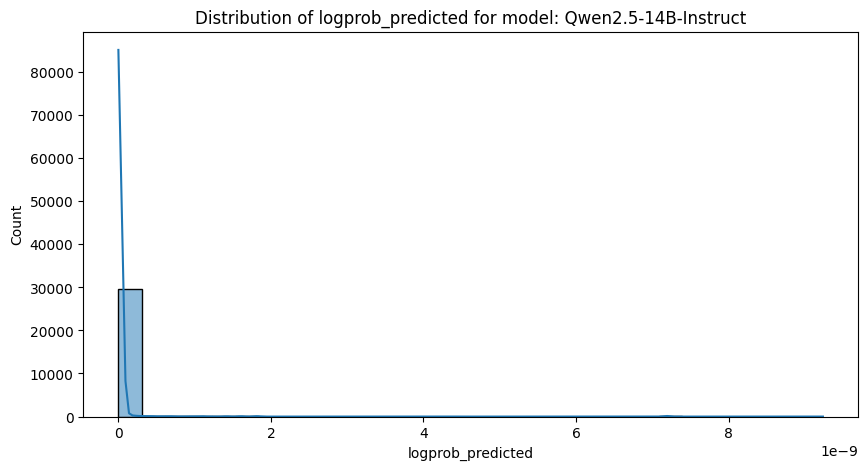

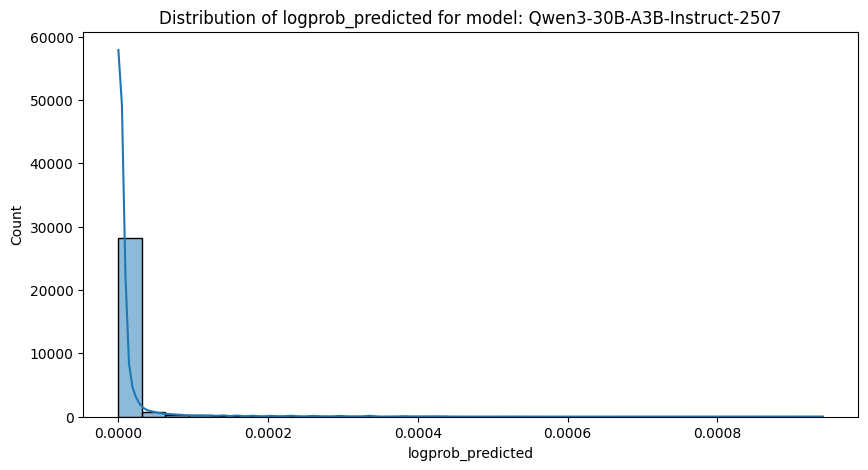

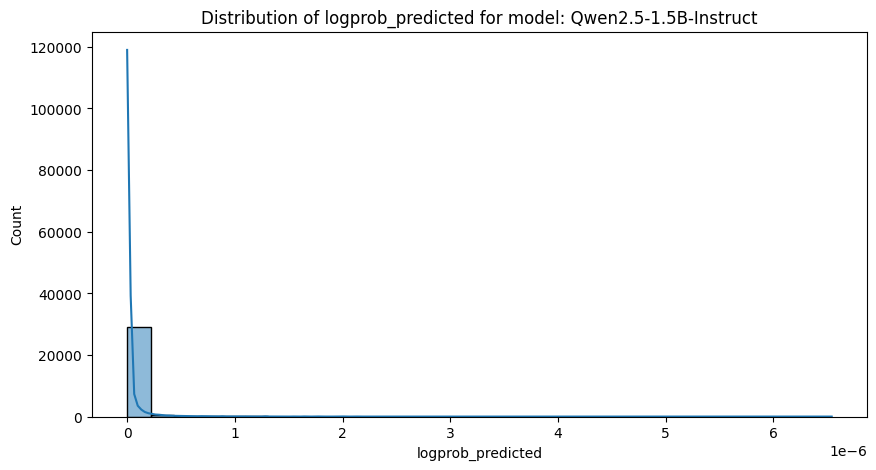

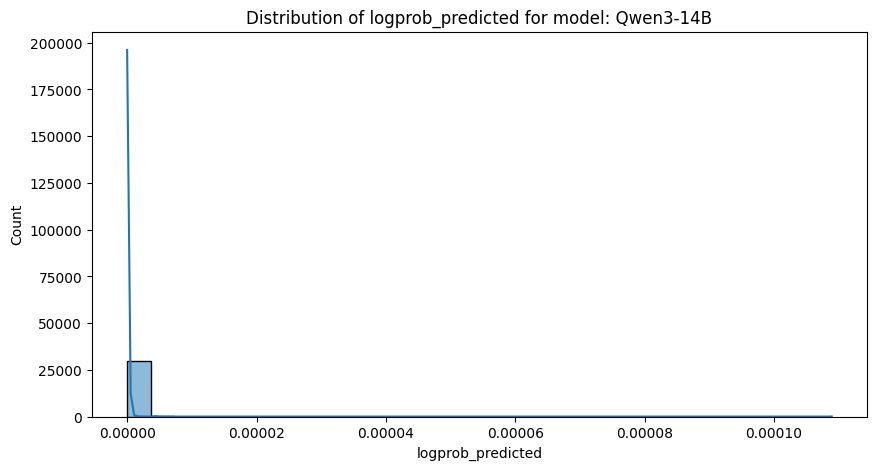

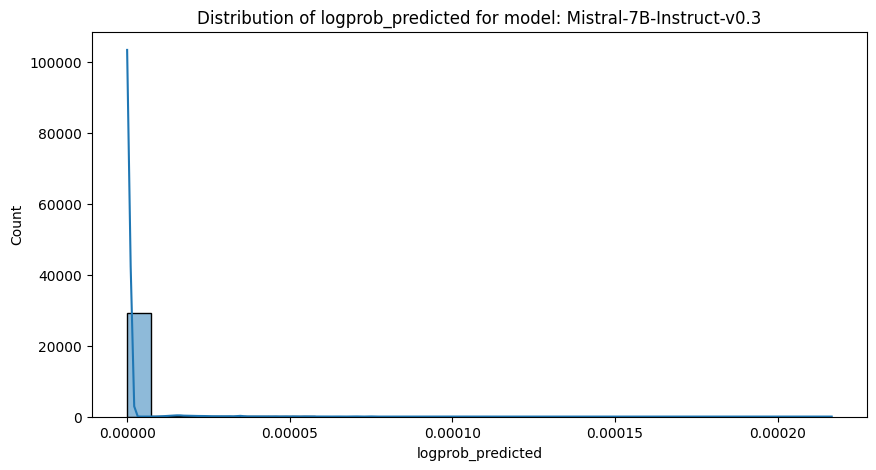

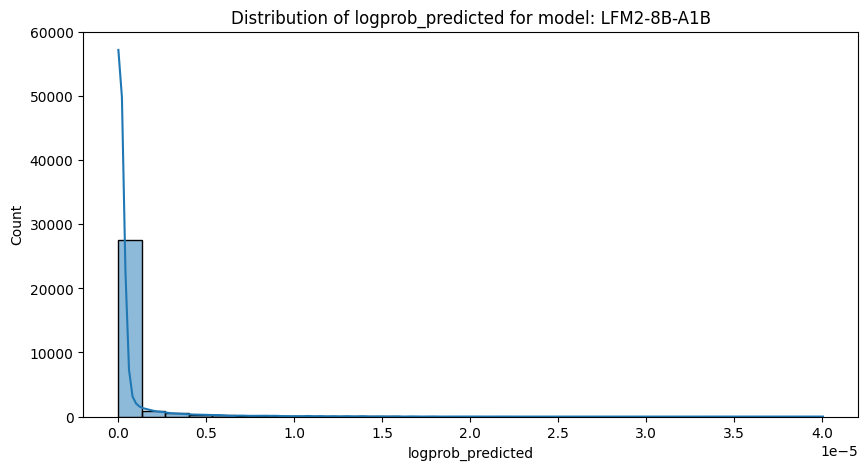

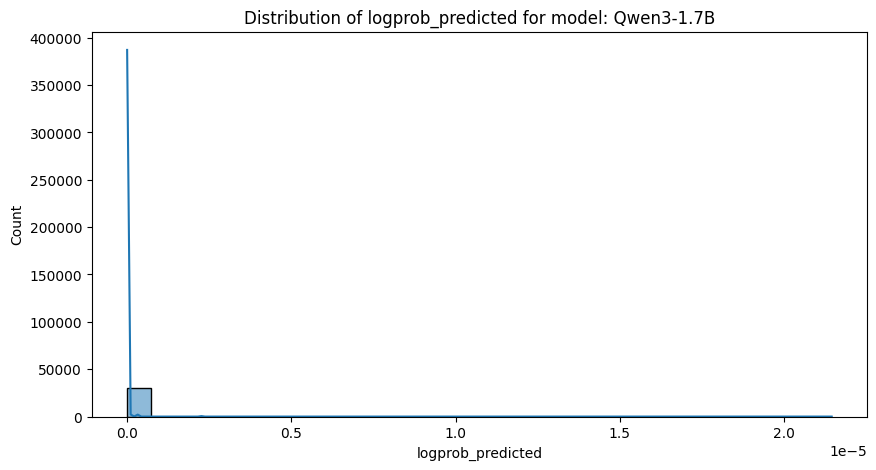

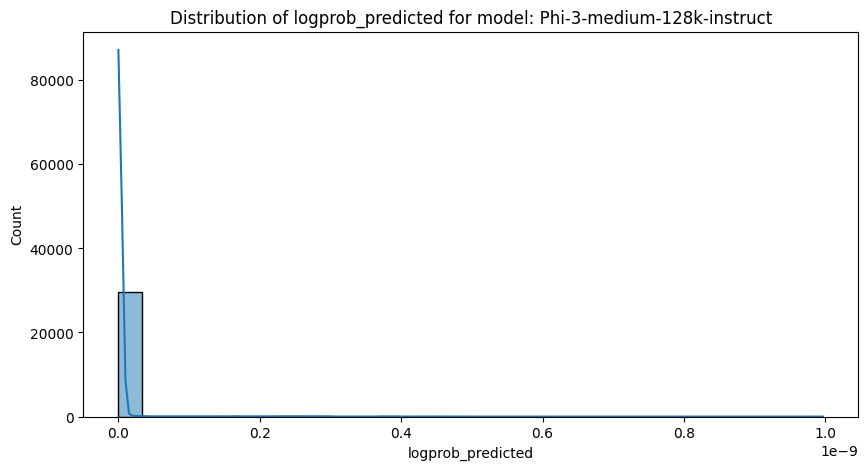

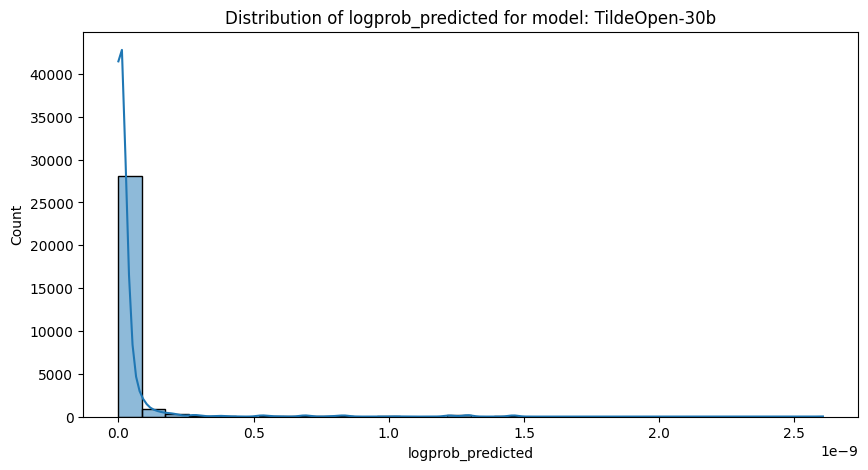

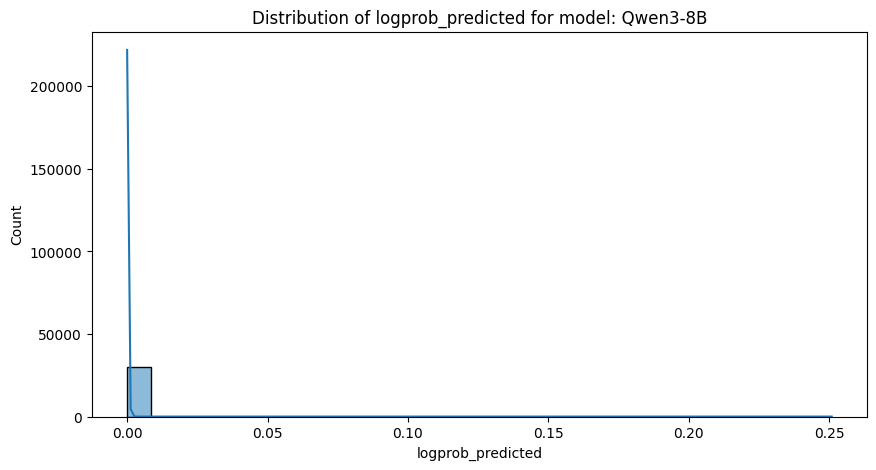

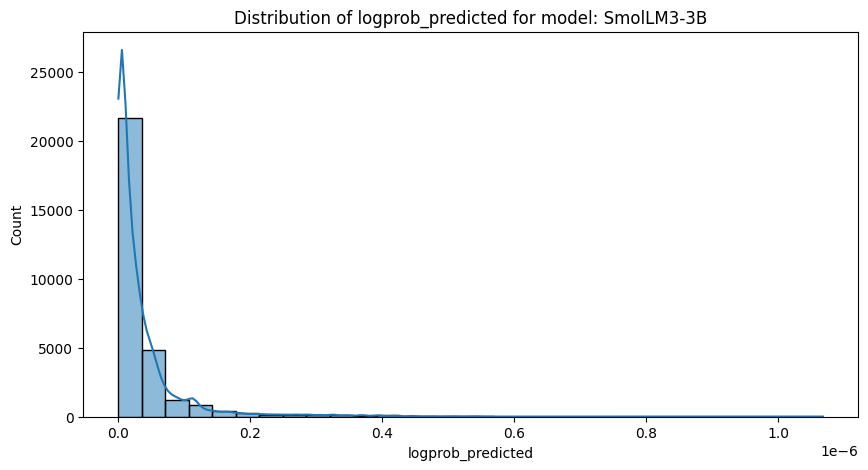

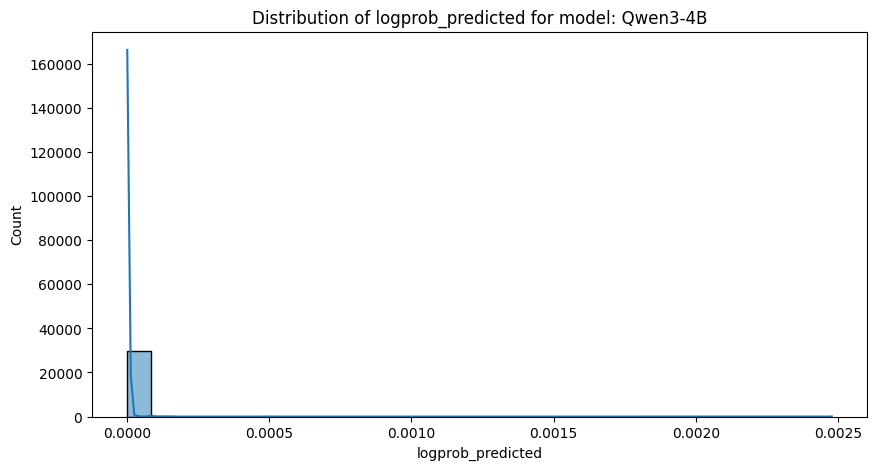

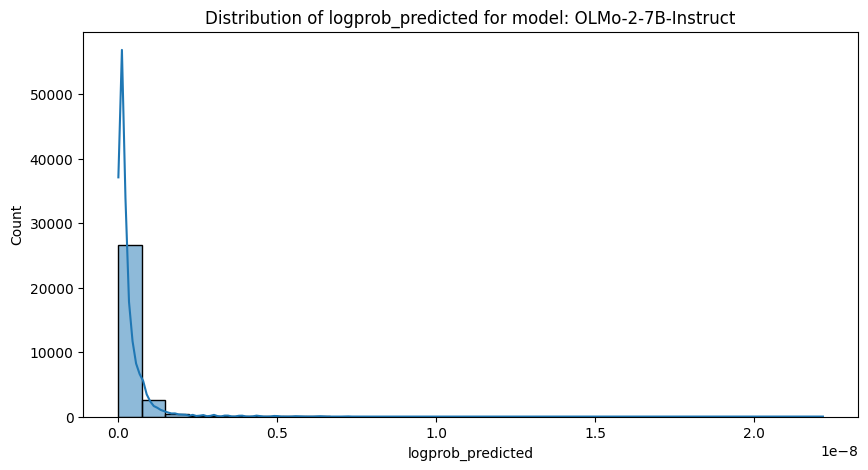

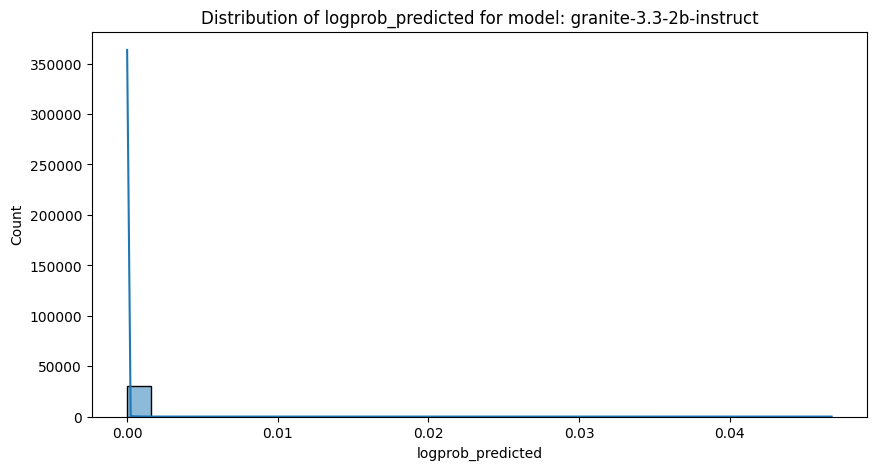

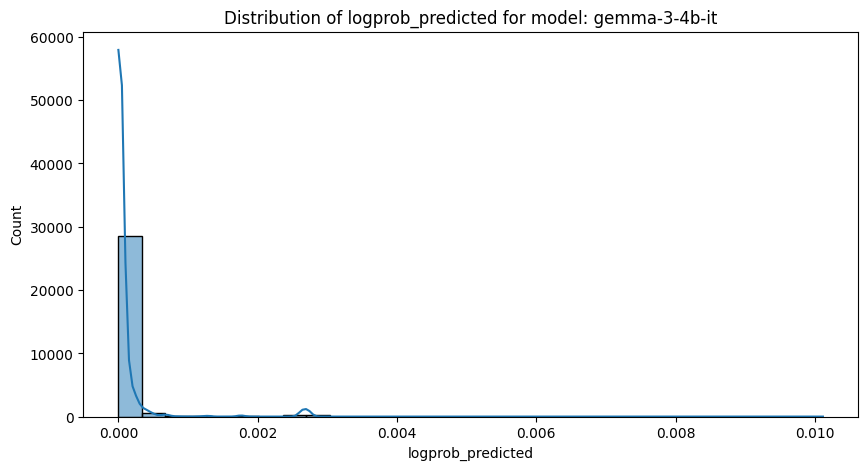

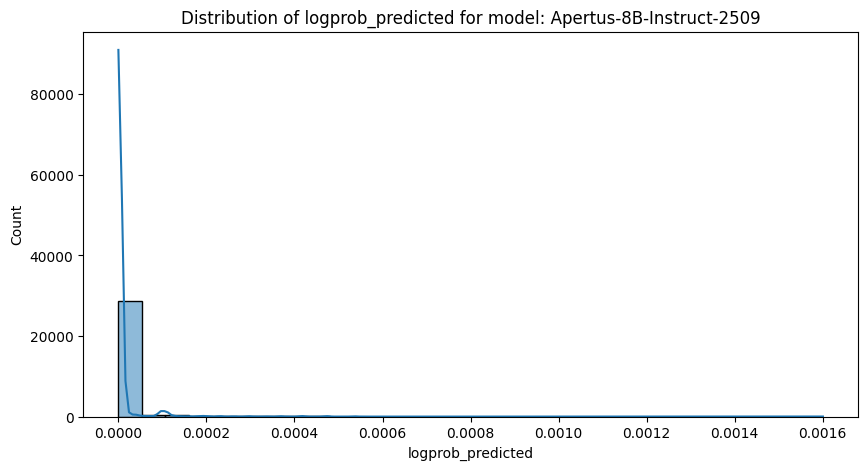

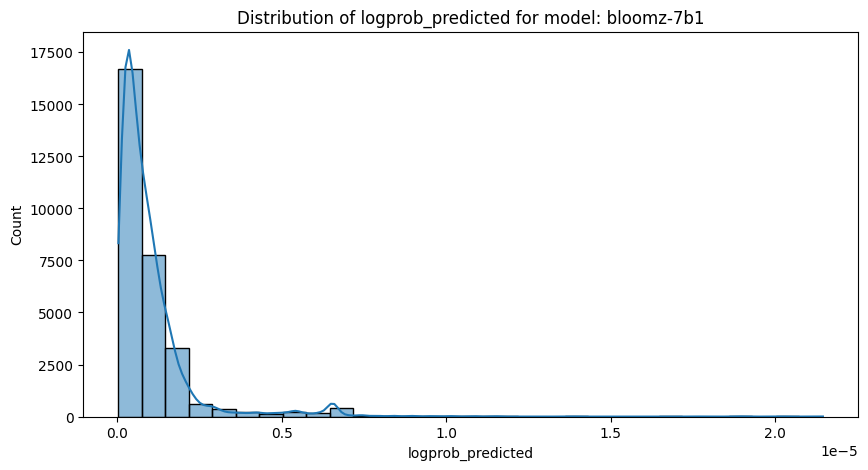

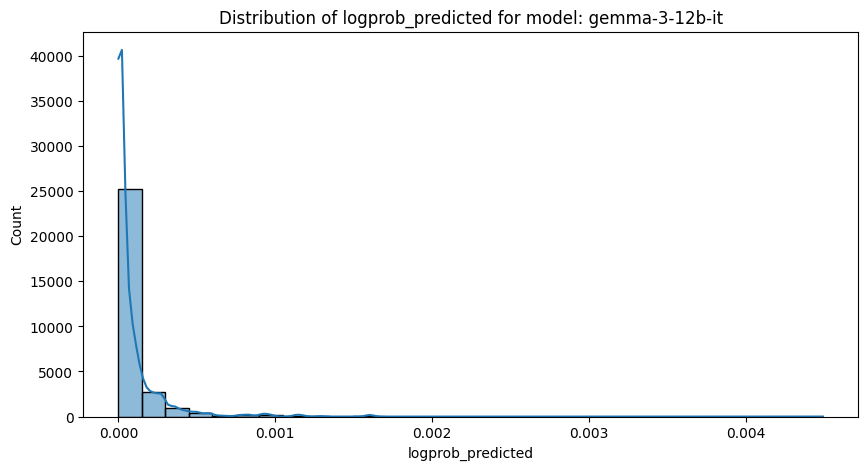

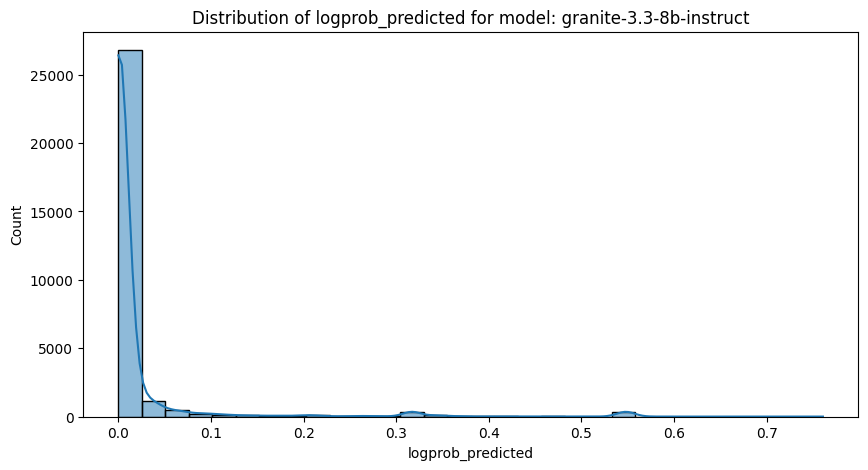

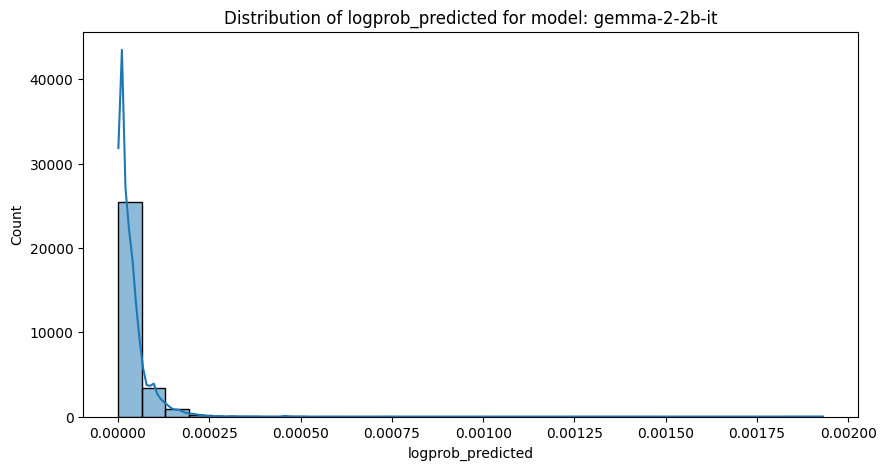

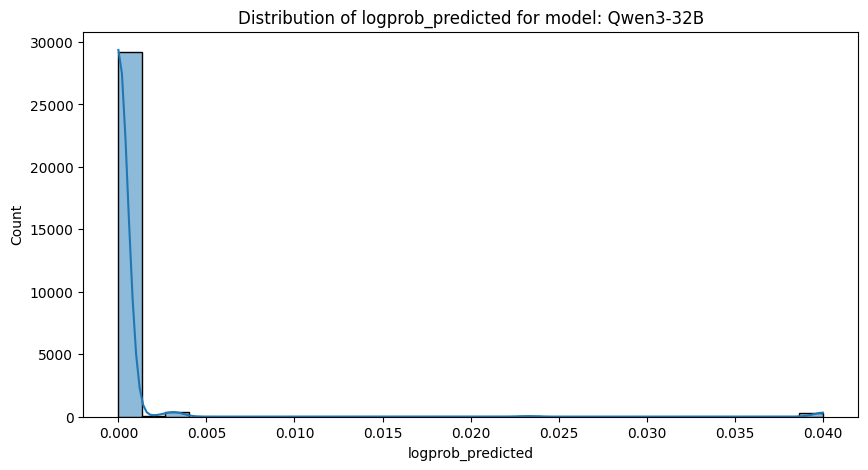

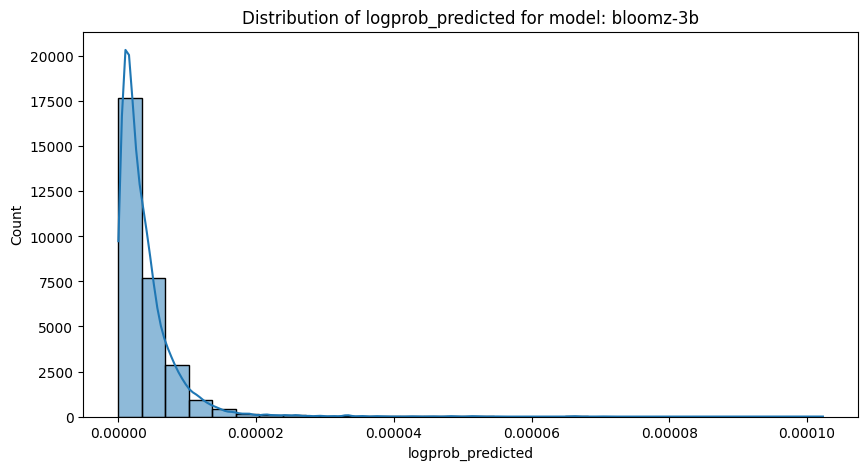

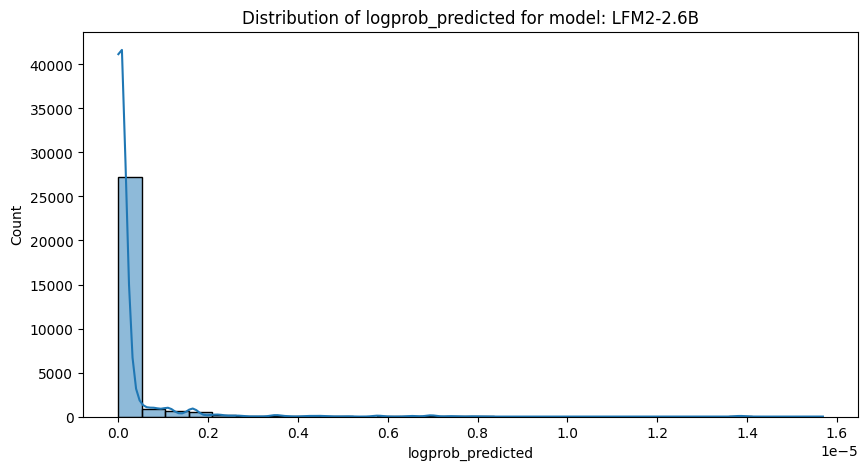

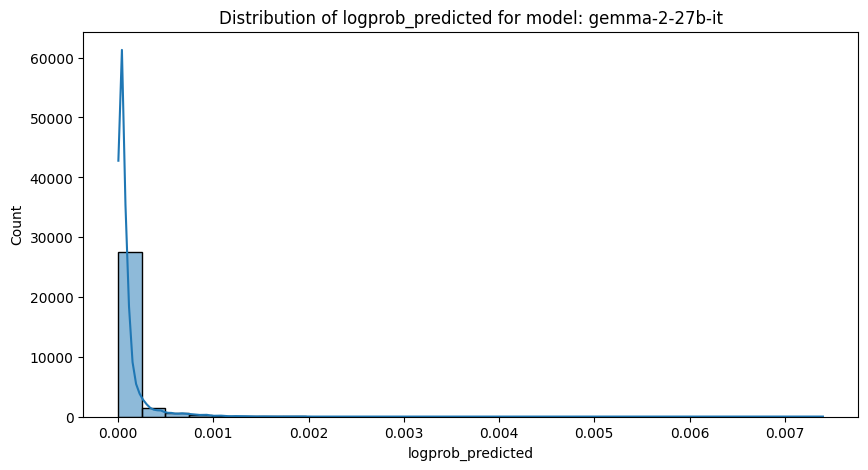

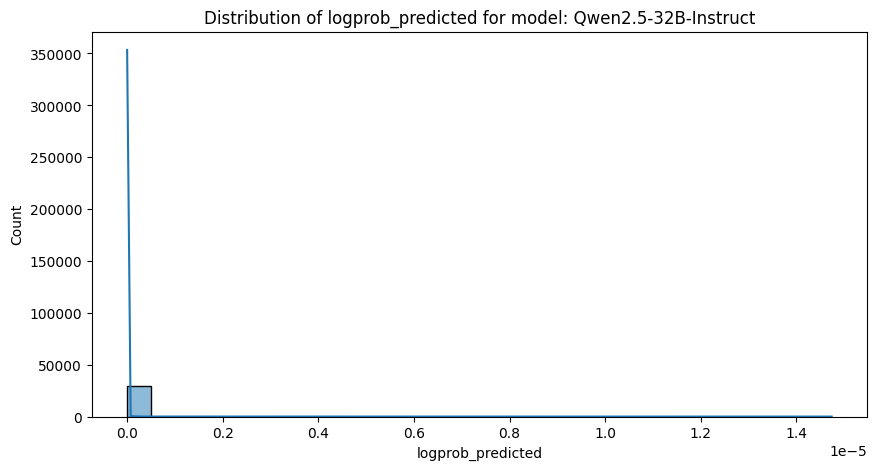

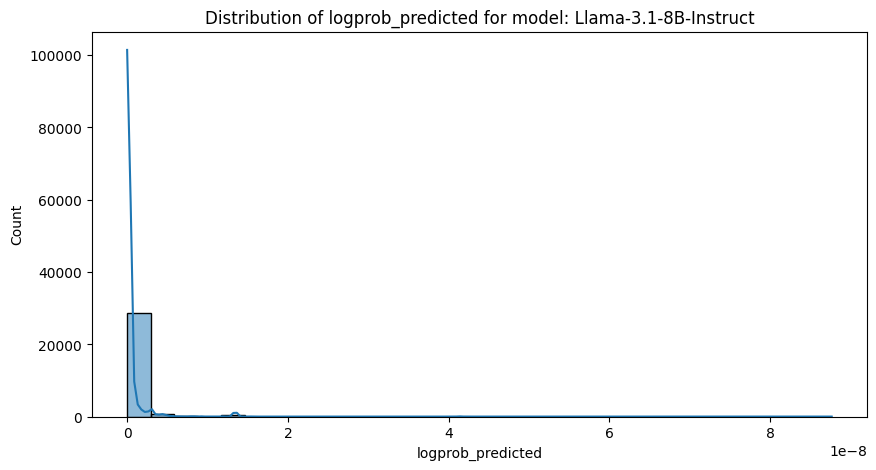

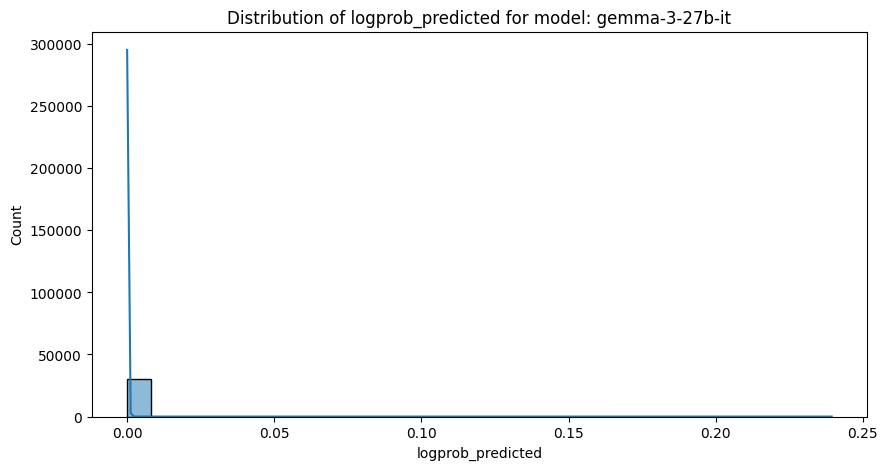

In [2]:
# Visualise distribution (focus on variance) per model of logprobs

model_names = merged_dospert_data['model'].unique()

for model_name in model_names:
    df_plot = merged_dospert_data[merged_dospert_data['model'] == model_name]
    
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df_plot, x="logprob_predicted", kde=True, bins=30)  # KDE optional
    plt.title(f'Distribution of logprob_predicted for model: {model_name}')
    plt.xlabel('logprob_predicted')
    plt.ylabel('Count')
    plt.show()

In [3]:
# ---- Cronbach's alpha per domain ----

# dictionary to store results
results = []

# loop through domains
for domain, domain_data in merged_dospert_data.groupby("domain"):
    
    # loop through models within this domain
    for model, model_data in domain_data.groupby("model"):
        
        # pivot wide format for Cronbach's alpha
        df_wide_domains = model_data.pivot_table(
            index="participant",
            columns="item",
            values="logprob_predicted"
        )
        
        # drop rows with missing data
        df_wide_domains = df_wide_domains.dropna(axis=0)
        
        # calculate Cronbach's alpha
        if df_wide_domains.shape[1] > 1:  # need at least 2 items
            alpha, ci = pg.cronbach_alpha(df_wide_domains)
        else:
            alpha, ci = None, (None, None)  # not enough items to compute
        
        # store results
        results.append({
            "domain": domain,
            "model": model,
            "alpha": alpha,
            "alpha_CI": ci
        })

# convert to DataFrame
alpha_df = pd.DataFrame(results)


In [4]:
alpha_df

,domain,model,alpha,alpha_CI
0,Ethical,Apertus-70B-Instruct-2509,0.112526,"[0.013, 0.206]"
1,Ethical,Apertus-8B-Instruct-2509,0.439867,"[0.377, 0.499]"
2,Ethical,Falcon-3-10B-Instruct,0.110381,"[0.011, 0.204]"
3,Ethical,Falcon-3-1B-Instruct,0.376833,"[0.307, 0.442]"
4,Ethical,Falcon-3-7B-Instruct,0.481650,"[0.424, 0.536]"
...,...,...,...,...
271,Social,gemma-3-4b-it,-0.048526,"[-0.166, 0.061]"
272,Social,gpt-oss-20b,0.380278,"[0.311, 0.445]"
273,Social,granite-3.3-2b-instruct,0.101076,"[0.0, 0.195]"
274,Social,granite-3.3-8b-instruct,-0.034564,"[-0.151, 0.074]"


In [5]:
# merged_dospert_data: long format with columns ['participant', 'item', 'model', 'logprob_predicted']

df_wide = merged_dospert_data.pivot_table(
    index=['model', 'participant'],
    columns='item',
    values='logprob_predicted'
).reset_index()

#df_wide: columns = wide format data with columns ['model', 'participant', item1, 2, ..., 40]

In [6]:
# ---- Cronbach's alpha ----
def cronbach_alpha(df):
    k = df.shape[1]
    item_vars = df.var(axis=0, ddof=1)
    total_var = df.sum(axis=1).var(ddof=1)
    return (k / (k - 1)) * (1 - item_vars.sum() / total_var)

alphas = {}
for m, sub in df_wide.groupby("model"):
    scores = sub.drop(columns=["model", "participant"])
    alpha = cronbach_alpha(scores)
    #print(f"Model {m}: alpha = {alpha:.3f}")
    alphas[m] = alpha

alpha_df = pd.DataFrame(list(alphas.items()), columns=["model", "alpha"])

In [7]:
# ---- split-half reliability -----

def split_half_reliability(df_items, n_splits=100):
    """Compute average split-half reliability (Spearman-Brown corrected)."""
    k = df_items.shape[1]
    colnames = df_items.columns
    results = []
    
    for _ in range(n_splits):
        shuffled = list(colnames)
        random.shuffle(shuffled)
        half1, half2 = shuffled[:k//2], shuffled[k//2:]
        
        s1 = df_items[half1].sum(axis=1)
        s2 = df_items[half2].sum(axis=1)
        
        r, _ = pearsonr(s1, s2)
        if np.isfinite(r): 
            r_sb = (2 * r) / (1 + r)
            results.append(r_sb)
    
    return np.mean(results), np.std(results)

split_results = {}

for m, sub in df_wide.groupby("model"):
    items = sub.drop(columns=["model", "participant"])
    mean_rsb, sd_rsb = split_half_reliability(items)
    split_results[m] = (mean_rsb, sd_rsb)

split_df = pd.DataFrame([
    {"model": m, "split_half_mean": mean, "split_half_sd": sd}
    for m, (mean, sd) in split_results.items()
])

In [8]:
# ---- ICC -----

df_long = merged_dospert_data.copy()

def compute_icc(df_long, model):
    """Compute ICC for one model (participant random effect)."""
    sub = df_long[df_long["model"] == model]
    # Random intercept model: logprob ~ 1 + (1|participant)
    md = mixedlm("logprob_predicted ~ 1", sub, groups=sub["participant"])
    mdf = md.fit(reml=True)
    
    var_participant = mdf.cov_re.iloc[0,0]
    var_residual = mdf.scale
    icc = var_participant / (var_participant + var_residual)
    return icc

icc_results = {}
for m in df_long["model"].unique():
    icc_results[m] = compute_icc(df_long, m)

icc_df = pd.DataFrame(list(icc_results.items()), columns=["model", "icc"])


/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: 

In [9]:
results_df = alpha_df.merge(split_df, on="model").merge(icc_df, on="model")
results_df

,model,alpha,split_half_mean,split_half_sd,icc
0,Apertus-70B-Instruct-2509,0.085554,0.107997,0.083695,1.610387e-10
1,Apertus-8B-Instruct-2509,0.113559,0.206427,0.108897,2.969209e-10
2,Falcon-3-10B-Instruct,0.063879,0.204242,0.105405,8.413294e-06
3,Falcon-3-1B-Instruct,0.363516,0.434338,0.045477,3.696443e-03
4,Falcon-3-7B-Instruct,-0.012409,-0.026582,0.119679,7.117041e-10
5,LFM2-1.2B,0.017069,0.095825,0.077646,2.351945e-10
6,LFM2-2.6B,0.225349,0.286431,0.100604,1.078812e-09
7,LFM2-8B-A1B,0.306166,0.380421,0.070722,5.221400e-10
8,Llama-3.1-70B-Instruct,0.202185,0.385425,0.180839,5.635089e-03
9,Llama-3.1-8B-Instruct,-0.013426,-0.001492,0.091218,2.277984e-10


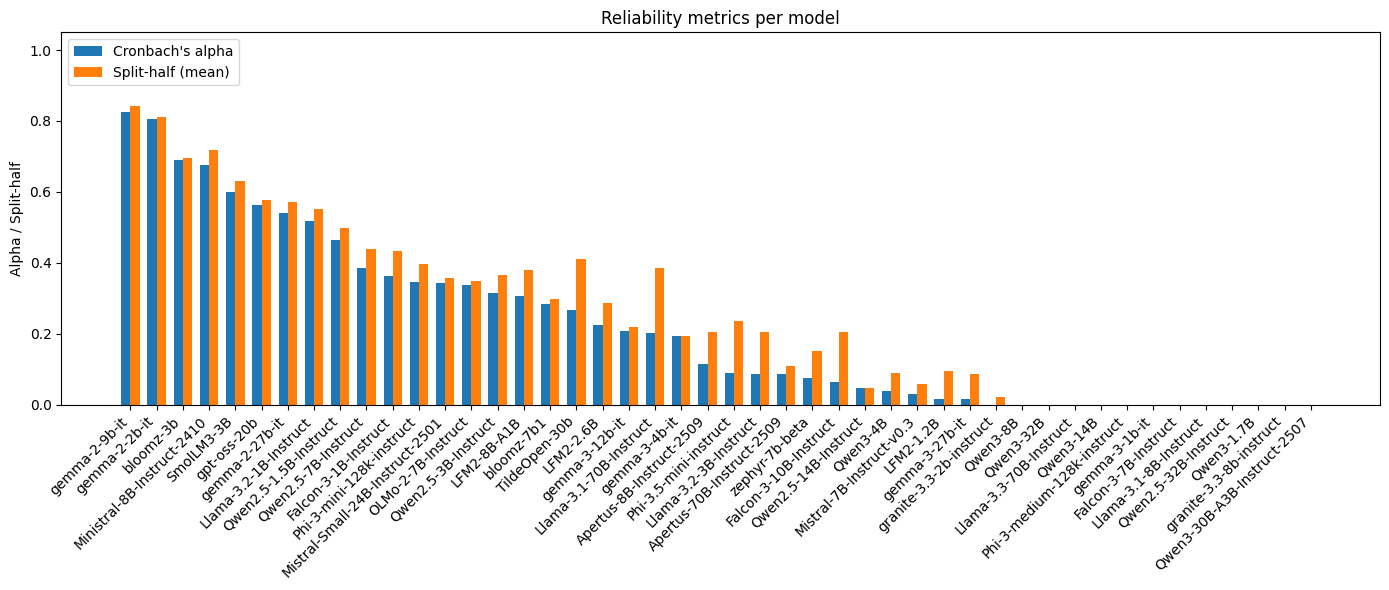

In [10]:
# Sort models by alpha for better readability
df_sorted = results_df.sort_values("alpha", ascending=False)

x = np.arange(len(df_sorted))  # positions for models
width = 0.35  # bar width

fig, ax1 = plt.subplots(figsize=(14,6))

# Bars for alpha and split-half
ax1.bar(x - width/2, df_sorted["alpha"], width, label="Cronbach's alpha")
ax1.bar(x + width/2, df_sorted["split_half_mean"], width, label="Split-half (mean)")

ax1.set_ylabel("Alpha / Split-half")
ax1.set_xticks(x)
ax1.set_xticklabels(df_sorted["model"], rotation=45, ha="right")
ax1.set_ylim(0, 1.05)
ax1.legend(loc="upper left")
ax1.set_title("Reliability metrics per model")

# Optional: plot ICC on secondary axis
# ax2 = ax1.twinx()
# ax2.plot(x, df_sorted["icc"], color="red", marker="o", linestyle='-', label="ICC")
# ax2.set_ylabel("ICC")
# ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


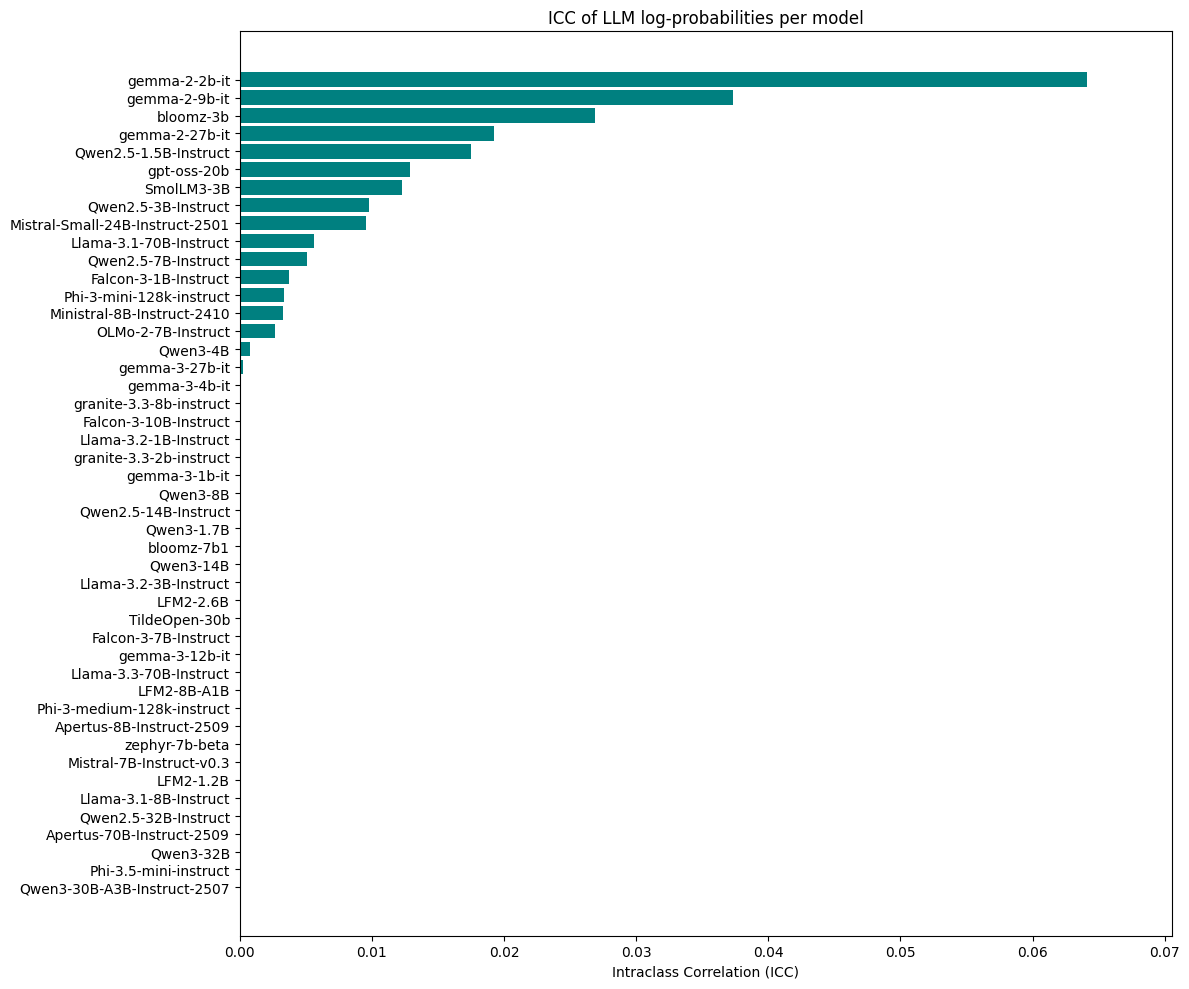

In [11]:
# Sort models by ICC for easier visualization
icc_sorted = results_df.sort_values("icc", ascending=True)
y = np.arange(len(icc_sorted))

plt.figure(figsize=(12,10))
plt.barh(y, icc_sorted["icc"], color="teal")
plt.yticks(y, icc_sorted["model"])
plt.xlabel("Intraclass Correlation (ICC)")
plt.title("ICC of LLM log-probabilities per model")
plt.xlim(0, icc_sorted["icc"].max()*1.1)  # add 10% padding
plt.tight_layout()
plt.show()

#ICC quantifies the proportion of variance in the LLM’s assigned log-probabilities that is attributable to differences between participants, as opposed to random variation across items or noise.

count    4.000000e+01
mean     2.065792e-09
std      1.267857e-08
min      2.029378e-17
25%      7.951918e-16
50%      1.300554e-14
75%      1.060355e-13
max      8.021753e-08
Name: logprob_predicted, dtype: float64
count    7.480000e+02
mean     1.508073e-06
std      7.202329e-06
min      3.340754e-10
25%      2.545717e-08
50%      1.261976e-07
75%      8.168891e-07
max      6.341814e-05
Name: logprob_predicted, dtype: float64


<Axes: ylabel='logprob_predicted'>

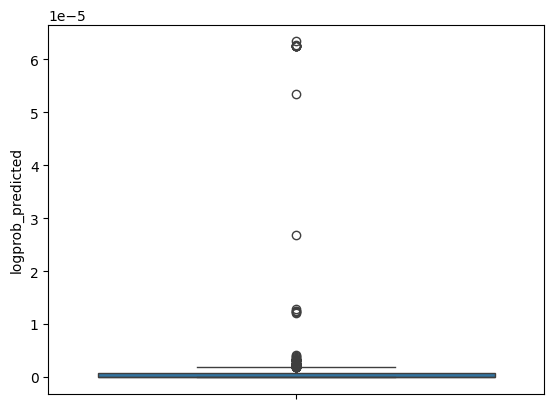

In [12]:
# is ICC so low because there is simply no variance between the logprobs assigned to different participants?

df_long_Qwen3_4b = df_long[df_long["model"] == "Qwen3-4B"]

participant_var_per_item = df_long_Qwen3_4b.groupby("item")["logprob_predicted"].var()
print(participant_var_per_item.describe())

participant_means = df_long_Qwen3_4b.groupby("participant")["logprob_predicted"].mean()
print(participant_means.describe())


import seaborn as sns
sns.boxplot(participant_means)

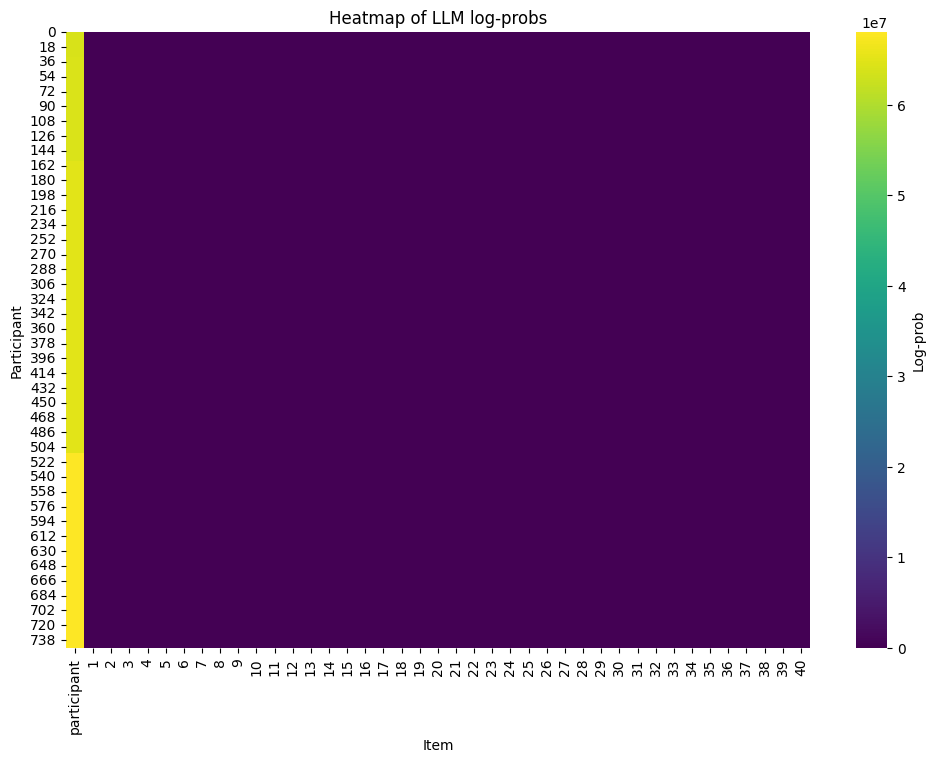

In [13]:
# Pivot to participants × items
heatmap_df = df_long_Qwen3_4b.pivot_table(
    index=['participant'],
    columns='item',
    values='logprob_predicted'
).reset_index()


plt.figure(figsize=(12,8))
sns.heatmap(heatmap_df, cmap="viridis", cbar_kws={'label':'Log-prob'})
plt.xlabel("Item")
plt.ylabel("Participant")
plt.title("Heatmap of LLM log-probs")
plt.show()


In [14]:
# packages
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import random
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

# Initialize empty list to store DataFrames
dospert_dataframes = []
path = "LLM_data"  # folder with CSVs

for file in glob.glob(os.path.join(path, "*_DOSPERT_prompting_results.csv")):
    model_name = os.path.basename(file).replace("_DOSPERT_prompting_results.csv", "")
    
    # Read the CSV
    df = pd.read_csv(file)
    
    # Append to list
    dospert_dataframes.append(df)
    
# Concatenate all DataFrames into one big DataFrame
merged_dospert_data = pd.concat(dospert_dataframes, ignore_index=True)
print(f"\nMerged DataFrame shape: {merged_dospert_data.shape}")
print(f"Total models: {merged_dospert_data['model'].nunique()}")
print(f"Models included: {sorted(merged_dospert_data['model'].unique())}")

# add column with predicted logprob for actual human answers
merged_dospert_data['logprob_predicted'] = merged_dospert_data.apply(
    lambda row: row[str(row['human_number'])], axis=1
)

# Check column names
print(f"\nColumns: {list(merged_dospert_data.columns)}")

# merged_dospert_data: long format with columns ['participant', 'item', 'model', 'logprob_predicted']
df_wide = merged_dospert_data.pivot_table(
    index=['model', 'participant'],
    columns='item',
    values='logprob_predicted'
).reset_index()

# ---- IMPROVED Cronbach's alpha ----
def cronbach_alpha(df):
    """
    Compute Cronbach's alpha with better numerical stability
    """
    # Remove any rows with missing values
    df_clean = df.dropna()
    if df_clean.empty:
        return np.nan
    
    k = df_clean.shape[1]  # number of items
    if k < 2:
        return np.nan
    
    # Calculate item variances
    item_vars = df_clean.var(axis=0, ddof=1)
    
    # Calculate total score variance
    total_scores = df_clean.sum(axis=1)
    total_var = total_scores.var(ddof=1)
    
    # Handle edge cases
    if total_var == 0:
        return np.nan
    
    # Cronbach's alpha formula
    alpha = (k / (k - 1)) * (1 - item_vars.sum() / total_var)
    return alpha

alphas = {}
for m, sub in df_wide.groupby("model"):
    scores = sub.drop(columns=["model", "participant"])
    alpha = cronbach_alpha(scores)
    alphas[m] = alpha

alpha_df = pd.DataFrame(list(alphas.items()), columns=["model", "alpha"])

# ---- FIXED split-half reliability -----
def split_half_reliability(df_items, n_splits=100):
    """Compute average split-half reliability (Spearman–Brown corrected)."""
    k = df_items.shape[1]
    if k < 2:
        return np.nan, np.nan
    
    colnames = df_items.columns.tolist()
    results = []
    
    for _ in range(n_splits):  # FIXED: was "for * in range(n*splits)"
        shuffled = colnames.copy()
        random.shuffle(shuffled)
        
        # Split into two halves
        half1, half2 = shuffled[:k//2], shuffled[k//2:k//2*2]  # Ensure equal lengths
        
        if len(half1) == 0 or len(half2) == 0:
            continue
            
        s1 = df_items[half1].sum(axis=1)
        s2 = df_items[half2].sum(axis=1)
        
        # Check for zero variance
        if s1.var() == 0 or s2.var() == 0:
            continue
            
        r, p_value = pearsonr(s1, s2)
        
        if np.isfinite(r) and r > -1:  # Avoid invalid correlations
            # Spearman-Brown correction
            r_sb = (2 * r) / (1 + r) if (1 + r) != 0 else np.nan
            if np.isfinite(r_sb):
                results.append(r_sb)
    
    if len(results) == 0:
        return np.nan, np.nan
    
    return np.mean(results), np.std(results)

split_results = {}
for m, sub in df_wide.groupby("model"):
    items = sub.drop(columns=["model", "participant"])
    mean_rsb, sd_rsb = split_half_reliability(items)
    split_results[m] = (mean_rsb, sd_rsb)

split_df = pd.DataFrame([
    {"model": m, "split_half_mean": mean, "split_half_sd": sd}
    for m, (mean, sd) in split_results.items()
])

# ---- IMPROVED ICC -----
def compute_icc(df_long, model):
    """Compute ICC for one model (participant random effect)."""
    sub = df_long[df_long["model"] == model].copy()
    
    # Check if we have enough data
    if len(sub) == 0 or sub['participant'].nunique() < 2:
        return np.nan
    
    try:
        # Random intercept model: logprob ~ 1 + (1|participant)
        md = mixedlm("logprob_predicted ~ 1", sub, groups=sub["participant"])
        mdf = md.fit(reml=True, disp=False)  # Suppress convergence warnings
        
        # Extract variance components
        var_participant = mdf.cov_re.iloc[0, 0]
        var_residual = mdf.scale
        
        # Calculate ICC
        icc = var_participant / (var_participant + var_residual)
        return icc
        
    except Exception as e:
        print(f"Warning: ICC computation failed for model {model}: {e}")
        return np.nan

icc_results = {}
for m in df_long["model"].unique():
    icc_results[m] = compute_icc(df_long, m)

icc_df = pd.DataFrame(list(icc_results.items()), columns=["model", "icc"])

# Merge all results
results_df = alpha_df.merge(split_df, on="model").merge(icc_df, on="model")

# Sort by alpha for better readability
results_df = results_df.sort_values('alpha', ascending=False)

print("\n" + "="*60)
print("RELIABILITY ANALYSIS RESULTS")
print("="*60)
print(results_df.round(4))

# ---- INTERPRETATION HELPER ----
def interpret_reliability(alpha, split_half, icc):
    """Provide interpretation guidelines for reliability measures"""
    interpretations = []
    
    # Cronbach's Alpha interpretation
    if alpha >= 0.9:
        alpha_interp = "Excellent"
    elif alpha >= 0.8:
        alpha_interp = "Good"
    elif alpha >= 0.7:
        alpha_interp = "Acceptable"
    elif alpha >= 0.6:
        alpha_interp = "Questionable"
    else:
        alpha_interp = "Poor"
    
    # Split-half interpretation (similar scale)
    if split_half >= 0.9:
        split_interp = "Excellent"
    elif split_half >= 0.8:
        split_interp = "Good"
    elif split_half >= 0.7:
        split_interp = "Acceptable"
    elif split_half >= 0.6:
        split_interp = "Questionable"
    else:
        split_interp = "Poor"
    
    # ICC interpretation
    if icc >= 0.75:
        icc_interp = "Excellent"
    elif icc >= 0.6:
        icc_interp = "Good"
    elif icc >= 0.4:
        icc_interp = "Fair"
    else:
        icc_interp = "Poor"
    
    return alpha_interp, split_interp, icc_interp

# Add interpretations to results
results_df[['alpha_interp', 'split_half_interp', 'icc_interp']] = results_df.apply(
    lambda row: interpret_reliability(row['alpha'], row['split_half_mean'], row['icc']), 
    axis=1, result_type='expand'
)

print("\n" + "="*60)
print("RELIABILITY INTERPRETATIONS")
print("="*60)
results_df[['model', 'alpha', 'alpha_interp', 'split_half_mean', 'split_half_interp', 'icc', 'icc_interp']].round(4)


Merged DataFrame shape: (2780240, 11)
Total models: 46
Models included: ['Apertus-70B-Instruct-2509', 'Apertus-8B-Instruct-2509', 'Falcon-3-10B-Instruct', 'Falcon-3-1B-Instruct', 'Falcon-3-7B-Instruct', 'LFM2-1.2B', 'LFM2-2.6B', 'LFM2-8B-A1B', 'Llama-3.1-70B-Instruct', 'Llama-3.1-8B-Instruct', 'Llama-3.2-1B-Instruct', 'Llama-3.2-3B-Instruct', 'Llama-3.3-70B-Instruct', 'Ministral-8B-Instruct-2410', 'Mistral-7B-Instruct-v0.3', 'Mistral-Small-24B-Instruct-2501', 'OLMo-2-7B-Instruct', 'Phi-3-medium-128k-instruct', 'Phi-3-mini-128k-instruct', 'Phi-3.5-mini-instruct', 'Qwen2.5-1.5B-Instruct', 'Qwen2.5-14B-Instruct', 'Qwen2.5-32B-Instruct', 'Qwen2.5-3B-Instruct', 'Qwen2.5-7B-Instruct', 'Qwen3-1.7B', 'Qwen3-14B', 'Qwen3-30B-A3B-Instruct-2507', 'Qwen3-32B', 'Qwen3-4B', 'Qwen3-8B', 'SmolLM3-3B', 'TildeOpen-30b', 'bloomz-3b', 'bloomz-7b1', 'gemma-2-27b-it', 'gemma-2-2b-it', 'gemma-2-9b-it', 'gemma-3-12b-it', 'gemma-3-1b-it', 'gemma-3-27b-it', 'gemma-3-4b-it', 'gpt-oss-20b', 'granite-3.3-2b-instr

/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: 


RELIABILITY ANALYSIS RESULTS
                              model   alpha  split_half_mean  split_half_sd  \
29                         Qwen3-4B  0.9604           0.9680         0.0096   
32                    TildeOpen-30b  0.9477           0.9596         0.0126   
37                    gemma-2-9b-it  0.9406           0.9462         0.0090   
41                    gemma-3-4b-it  0.9387           0.9489         0.0164   
5                         LFM2-1.2B  0.9275           0.9354         0.0134   
19            Phi-3.5-mini-instruct  0.9274           0.9342         0.0182   
26                        Qwen3-14B  0.9273           0.9390         0.0111   
27      Qwen3-30B-A3B-Instruct-2507  0.9266           0.9326         0.0109   
18         Phi-3-mini-128k-instruct  0.9195           0.9341         0.0245   
28                        Qwen3-32B  0.9085           0.9184         0.0187   
38                   gemma-3-12b-it  0.9074           0.9175         0.0249   
31                    

/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


,model,alpha,alpha_interp,split_half_mean,split_half_interp,icc,icc_interp
29,Qwen3-4B,0.9604,Excellent,0.9680,Excellent,0.0008,Poor
32,TildeOpen-30b,0.9477,Excellent,0.9596,Excellent,0.0000,Poor
37,gemma-2-9b-it,0.9406,Excellent,0.9462,Excellent,0.0373,Poor
41,gemma-3-4b-it,0.9387,Excellent,0.9489,Excellent,0.0001,Poor
5,LFM2-1.2B,0.9275,Excellent,0.9354,Excellent,0.0000,Poor
19,Phi-3.5-mini-instruct,0.9274,Excellent,0.9342,Excellent,0.0000,Poor
26,Qwen3-14B,0.9273,Excellent,0.9390,Excellent,0.0000,Poor
27,Qwen3-30B-A3B-Instruct-2507,0.9266,Excellent,0.9326,Excellent,0.0000,Poor
18,Phi-3-mini-128k-instruct,0.9195,Excellent,0.9341,Excellent,0.0033,Poor
28,Qwen3-32B,0.9085,Excellent,0.9184,Excellent,0.0000,Poor


In [15]:
# Diagnostic code to understand the ICC convergence warnings

def detailed_icc_analysis(df_long, model):
    """
    Compute ICC with detailed diagnostics to understand convergence issues
    """
    sub = df_long[df_long["model"] == model].copy()
    
    print(f"\n=== DIAGNOSTIC ANALYSIS FOR {model} ===")
    print(f"Number of observations: {len(sub)}")
    print(f"Number of participants: {sub['participant'].nunique()}")
    print(f"Number of items: {sub['item'].nunique()}")
    
    # Check logprob distribution
    logprobs = sub['logprob_predicted']
    print(f"\nLogprob statistics:")
    print(f"  Mean: {logprobs.mean():.6f}")
    print(f"  Std:  {logprobs.std():.6f}")
    print(f"  Min:  {logprobs.min():.6f}")
    print(f"  Max:  {logprobs.max():.6f}")
    print(f"  Range: {logprobs.max() - logprobs.min():.6f}")
    
    # Check participant-level variation
    participant_means = sub.groupby('participant')['logprob_predicted'].mean()
    print(f"\nParticipant-level variation:")
    print(f"  Between-participant std: {participant_means.std():.6f}")
    print(f"  Within-participant std:  {sub.groupby('participant')['logprob_predicted'].std().mean():.6f}")
    
    # Check if there's any meaningful variation between participants
    participant_range = participant_means.max() - participant_means.min()
    print(f"  Range of participant means: {participant_range:.6f}")
    
    try:
        # Fit the model with more detailed output
        md = mixedlm("logprob_predicted ~ 1", sub, groups=sub["participant"])
        mdf = md.fit(reml=True, disp=False)
        
        # Extract variance components
        var_participant = mdf.cov_re.iloc[0, 0]
        var_residual = mdf.scale
        
        print(f"\nVariance Components:")
        print(f"  Participant variance: {var_participant:.8f}")
        print(f"  Residual variance:    {var_residual:.8f}")
        print(f"  Total variance:       {var_participant + var_residual:.8f}")
        
        # Calculate ICC
        icc = var_participant / (var_participant + var_residual)
        print(f"  ICC: {icc:.6f}")
        
        # Check if we're at the boundary
        if var_participant < 1e-6:
            print("BOUNDARY ISSUE: Participant variance ≈ 0")
            print("     This means the model cannot detect meaningful individual differences")
        
        # Alternative ICC calculation using ANOVA approach
        from scipy import stats
        
        # One-way ANOVA to get between vs within group variance
        participant_groups = [group['logprob_predicted'].values for name, group in sub.groupby('participant')]
        f_stat, p_val = stats.f_oneway(*participant_groups)
        
        print(f"\nOne-way ANOVA check:")
        print(f"  F-statistic: {f_stat:.6f}")
        print(f"  p-value: {p_val:.6f}")
        
        if p_val > 0.05:
            print("No significant differences between participants detected")
        
        return icc, var_participant, var_residual
        
    except Exception as e:
        print(f"Model fitting failed: {e}")
        return np.nan, np.nan, np.nan

# Run diagnostic for a few models
test_models = ['Qwen3-4B', 'Mistral-7B-Instruct-v0.3', 'zephyr-7b-beta']

for model in test_models:
    if model in df_long['model'].unique():
        detailed_icc_analysis(df_long, model)
        print("\n" + "="*60)

# ---- Alternative reliability measure ----
def alternative_reliability_measure(df_long, model):
    """
    Calculate an alternative reliability measure based on the correlation
    between participant means across items
    """
    sub = df_long[df_long["model"] == model].copy()
    
    # Create participant × item matrix
    pivot = sub.pivot_table(
        index='participant', 
        columns='item', 
        values='logprob_predicted'
    )
    
    if pivot.empty:
        return np.nan
    
    # Calculate correlation between random splits of items
    n_items = len(pivot.columns)
    if n_items < 4:
        return np.nan
    
    # Split items randomly multiple times and correlate participant means
    correlations = []
    for _ in range(100):
        items = list(pivot.columns)
        random.shuffle(items)
        
        half1 = items[:n_items//2]
        half2 = items[n_items//2:n_items//2*2]
        
        if len(half1) == 0 or len(half2) == 0:
            continue
            
        mean1 = pivot[half1].mean(axis=1)
        mean2 = pivot[half2].mean(axis=1)
        
        # Remove participants with missing data
        valid_mask = ~(mean1.isna() | mean2.isna())
        if valid_mask.sum() < 2:
            continue
            
        corr, _ = pearsonr(mean1[valid_mask], mean2[valid_mask])
        if np.isfinite(corr):
            correlations.append(corr)
    
    if len(correlations) == 0:
        return np.nan
    
    return np.mean(correlations)

print("\n" + "="*60)
print("ALTERNATIVE PARTICIPANT-LEVEL RELIABILITY")
print("="*60)

alt_reliability = {}
for model in df_long['model'].unique():
    alt_rel = alternative_reliability_measure(df_long, model)
    alt_reliability[model] = alt_rel
    print(f"{model}: {alt_rel:.4f}")


=== DIAGNOSTIC ANALYSIS FOR Qwen3-4B ===
Number of observations: 29960
Number of participants: 748
Number of items: 40

Logprob statistics:
  Mean: 0.000002
  Std:  0.000046
  Min:  0.000000
  Max:  0.002479
  Range: 0.002479

Participant-level variation:
  Between-participant std: 0.000007
  Within-participant std:  0.000009
  Range of participant means: 0.000063


/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimi


Variance Components:
  Participant variance: 0.00000000
  Residual variance:    0.00000000
  Total variance:       0.00000000
  ICC: 0.000801
BOUNDARY ISSUE: Participant variance ≈ 0
     This means the model cannot detect meaningful individual differences

One-way ANOVA check:
  F-statistic: 0.996067
  p-value: 0.523348
No significant differences between participants detected


=== DIAGNOSTIC ANALYSIS FOR Mistral-7B-Instruct-v0.3 ===
Number of observations: 29960
Number of participants: 748
Number of items: 40

Logprob statistics:
  Mean: 0.000001
  Std:  0.000006
  Min:  0.000000
  Max:  0.000217
  Range: 0.000217

Participant-level variation:
  Between-participant std: 0.000001
  Within-participant std:  0.000005
  Range of participant means: 0.000005


/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)



Variance Components:
  Participant variance: 0.00000000
  Residual variance:    0.00000000
  Total variance:       0.00000000
  ICC: 0.000000
BOUNDARY ISSUE: Participant variance ≈ 0
     This means the model cannot detect meaningful individual differences

One-way ANOVA check:
  F-statistic: 0.425391
  p-value: 1.000000
No significant differences between participants detected


=== DIAGNOSTIC ANALYSIS FOR zephyr-7b-beta ===
Number of observations: 29960
Number of participants: 748
Number of items: 40

Logprob statistics:
  Mean: 0.000005
  Std:  0.000051
  Min:  0.000000
  Max:  0.003607
  Range: 0.003607

Participant-level variation:
  Between-participant std: 0.000007
  Within-participant std:  0.000031
  Range of participant means: 0.000097


/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



Variance Components:
  Participant variance: 0.00000000
  Residual variance:    0.00000000
  Total variance:       0.00000000
  ICC: 0.000000
BOUNDARY ISSUE: Participant variance ≈ 0
     This means the model cannot detect meaningful individual differences

One-way ANOVA check:
  F-statistic: 0.723092
  p-value: 1.000000
No significant differences between participants detected


ALTERNATIVE PARTICIPANT-LEVEL RELIABILITY
Phi-3.5-mini-instruct: 0.1495
Ministral-8B-Instruct-2410: 0.5626
Llama-3.2-3B-Instruct: 0.1145
Falcon-3-10B-Instruct: 0.1400
Apertus-70B-Instruct-2509: 0.0515
Falcon-3-1B-Instruct: 0.2823
Llama-3.1-70B-Instruct: 0.2492
Mistral-Small-24B-Instruct-2501: 0.2285
gemma-2-9b-it: 0.7372
LFM2-1.2B: 0.0461
zephyr-7b-beta: 0.0906
Llama-3.3-70B-Instruct: -0.0521
Qwen2.5-7B-Instruct: 0.2780
Llama-3.2-1B-Instruct: 0.3903
gpt-oss-20b: 0.3975
gemma-3-1b-it: -0.0252
Phi-3-mini-128k-instruct: 0.2494
Falcon-3-7B-Instruct: -0.0082
Qwen2.5-3B-Instruct: 0.2219
Qwen2.5-14B-Instruct: 0.0305
